# Final Project Report
## Names: Anish Yakkala, Adrien Chaussabel, Lemar Popal

### Imports

In [ ]:
# Data Munging
import pandas as pd
import numpy as np


# ML
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# etc
import re
import json
import csv
import threading
import os
import pickle
import datetime
import datetime as dt
import matplotlib.pyplot as plt


# Financial Data
import yfinance as yf
import yahoofinancials

## Data Munging and Data Manipulation Functions

In [2]:
def min_max_date(df):
    """
    Get the min and max date of the ticker being mentioned in our WSB dataset
    """
    min_date = df.sort_values('datetime').iloc[0]["datetime"].date()
    max_date = df.sort_values('datetime', ascending= False).iloc[0]["datetime"].date()
    return(min_date, max_date)

def explode_action_column(df):
    """
    Explodes columns of
    dict(puts: [., ., .,]
         calls: [., ., .,]
         sell: [., ., .,]
         buy: [., ., .,])
         
    into four columns ...
    |puts|calls|sell|buy|
    """
    return pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)

def date_from_datetime(df):
    """
    Make datetime to date
    """
    df_copy = df.copy()
    df_copy["Date"] = df_copy["datetime"].dt.date
    return df_copy

def flatten_filter(df, ticker, filter = True):
    """
    Explodes the column of lists of tickers into multiple rows and then filter for ticker
    """
    df_copy = df.copy()
    df_flatten = df_copy.explode('tickers')
    if filter:
        df_flatten = df_flatten[df_flatten['tickers'] == ticker]
    else:
        return df_flatten
    return df_flatten

def indicator_actions(df, ticker):
    """
    Make indicator variables for ticker instead of list of tickers
    """
    df_copy = df.copy()
    df_copy = explode_action_column(df_copy)
    df_copy["puts"] = ((df_copy["puts"].apply(len) != 0) & 
                      (df_copy["puts"].astype('str').str.contains(ticker))).astype(int)
    df_copy["calls"] = ((df_copy["calls"].apply(len) != 0) & 
                       (df_copy["calls"].astype('str').str.contains(ticker))).astype(int)
    df_copy["buy"] = ((df_copy["buy"].apply(len) != 0) & 
                     (df_copy["buy"].astype('str').str.contains(ticker))).astype(int)
    df_copy["sell"] = ((df_copy["sell"].apply(len) != 0) & 
                      (df_copy["sell"].astype('str').str.contains(ticker))).astype(int)
    return df_copy

def plot_actions(df, ticker, min_date, max_date, hide_score = True):
    """
    Plot the aggregate sum of sell, buy, calls ,puts for each day within range for a specific ticker
    """
    df_copy = df.copy()
    
    # Aggregate financial action frequency per day
    if hide_score:
        agg_sell = df_copy[['Date','sell','buy','calls','puts']].groupby('Date').agg('sum')
    else:
        agg_sell = df_copy[['Date','sell','buy','calls','puts','score','ups']].groupby('Date').agg('sum')


    # Filter for range specified
    mask = (agg_sell.index > pd.to_datetime("2018-01-01").date()) & (agg_sell.index <= max_date)

    agg_sell.loc[mask].plot(figsize=(12, 10), linewidth=2.5)
    plt.xlabel("Date", labelpad=15)
    plt.ylabel("Movement Mentions", labelpad=15)
    plt.title("Movement mentions for {0} from {1} to {2}".format(ticker, str(min_date), str(max_date)), y=1.02, fontsize=22);

def plot_stock_vs_wsb(df,ticker, min_date, max_date, stock_col, action_col):
    """
    Plot the a specfic financial action mention in WSB comments vs historical data
    """
    df_copy = df.copy()
    
    # Aggregate financial action frequency per day
    agg_sell = df_copy[['Date','sell','buy','calls','puts','score','ups']].groupby('Date').agg('sum')
    
    
    # Get the minimum date of that ticker mentioned on our WSB comment
    MIN_DATE, MAX_DATE = min_max_date(df)

    # Pull the data from yahoo finance api
    stock_data = yf.download(ticker, start = MIN_DATE, end = MAX_DATE)
    
    # Filter for range specified
    mask = (stock_data.index > np.datetime64(str(min_date))) & (stock_data.index <= np.datetime64(max_date))

    plot_multi(stock_data.loc[mask].join(other = agg_sell)[[stock_col,action_col]], figsize=(10,5))

    plt.xlabel("Date", labelpad=15)
    plt.ylabel("Daily {0} mentions".format(action_col), labelpad=15)
    plt.title("Daily {1} mentions vs {2} from {3} to {4} for {0}".format(ticker, action_col, stock_col, str(min_date), str(max_date)), y=1.02, fontsize=22);

We now load in the data and with a pickle file because it takes a large amount of time to go through the dataset and pull the tickers and comment data.

In [32]:
data = pickle.load(open("wsb.pkl", "rb"))

data.head()

,body,score_hidden,archived,name,author,downs,created_utc,subreddit_id,link_id,parent_id,...,gilded,id,subreddit,ups,author_flair_text,author_flair_css_class,distinguished,tickers,datetime,sentiment
0,[deleted],0.0,1.0,t1_chi0ufo,[deleted],0.0,1400098596,t5_2th52,t3_25jeio,t1_chhzelx,...,0,chi0ufo,wallstreetbets,0.0,NaN,NaN,NaN,[],2014-05-14 20:16:36,"{'puts': [], 'calls': [], 'buy': [], 'sell': []}"
1,"Lol. Yeah, Welp.",0.0,0.0,t1_cl52foo,JamesAQuintero,0.0,1412888184,t5_2th52,t3_2ikdc5,t1_cl47s92,...,0,cl52foo,wallstreetbets,1.0,NaN,NaN,NaN,[],2014-10-09 20:56:24,"{'puts': [], 'calls': [], 'buy': [], 'sell': []}"
2,[deleted],0.0,1.0,t1_ch5wdhy,[deleted],0.0,1398860210,t5_2th52,t3_24a77l,t1_ch5diku,...,0,ch5wdhy,wallstreetbets,1.0,NaN,NaN,NaN,[],2014-04-30 12:16:50,"{'puts': [], 'calls': [], 'buy': [], 'sell': []}"
3,Crypto miners is not a significant enough mark...,0.0,1.0,t1_cfj9fzo,Zytran,0.0,1392824901,t5_2th52,t3_1y409u,t3_1y409u,...,0,cfj9fzo,wallstreetbets,1.0,NaN,NaN,NaN,[AMD],2014-02-19 15:48:21,"{'puts': [], 'calls': [], 'buy': ['AMD'], 'sel..."
4,Sold a covered call at 560. I almost wish it d...,0.0,1.0,t1_ch0jw88,FarmPal,0.0,1398311440,t5_2th52,t3_23sjde,t3_23sjde,...,0,ch0jw88,wallstreetbets,1.0,NaN,NaN,NaN,[],2014-04-24 03:50:40,"{'puts': [], 'calls': [], 'buy': [], 'sell': []}"


We focus in on `TSLA` because it is a pretty popular stock with high volume.

In [33]:
ticker = "TSLA"
tesla_df = date_from_datetime(flatten_filter(data, ticker))

tesla_df.head()

,body,score_hidden,archived,name,author,downs,created_utc,subreddit_id,link_id,parent_id,...,id,subreddit,ups,author_flair_text,author_flair_css_class,distinguished,tickers,datetime,sentiment,Date
41,TSLA is trading on news. Everytime some bad ne...,0.0,1.0,t1_cjjw3r1,johnnyblac,0.0,1407446182,t5_2th52,t3_2cwmpg,t3_2cwmpg,...,cjjw3r1,wallstreetbets,1.0,NaN,NaN,NaN,TSLA,2014-08-07 21:16:22,"{'puts': [], 'calls': [], 'buy': ['TSLA'], 'se...",2014-08-07
190,Lots of big companies dipped today. Held onto ...,0.0,1.0,t1_ch27wgr,FarmPal,0.0,1398473973,t5_2th52,t3_23ynb6,t3_23ynb6,...,ch27wgr,wallstreetbets,1.0,NaN,NaN,NaN,TSLA,2014-04-26 00:59:33,"{'puts': [], 'calls': [], 'buy': ['MSFT', 'AMZ...",2014-04-26
357,Unless TSLA pulls a TRIP and rallies back to g...,0.0,1.0,t1_chchhfa,nbikkasa,0.0,1399523715,t5_2th52,t3_24zrss,t3_24zrss,...,chchhfa,wallstreetbets,1.0,NaN,NaN,NaN,TSLA,2014-05-08 04:35:15,"{'puts': [], 'calls': [], 'buy': ['TSLA', 'TRI...",2014-05-08
531,If you have TSLA stock your already making mon...,0.0,1.0,t1_cfozwpc,benboggs,0.0,1393395023,t5_2th52,t3_1yxv9r,t1_cfoz9jh,...,cfozwpc,wallstreetbets,0.0,NaN,NaN,NaN,TSLA,2014-02-26 06:10:23,"{'puts': [], 'calls': [], 'buy': ['TSLA'], 'se...",2014-02-26
699,&gt; Trash of a stock.\n\nHardly. They're doin...,0.0,1.0,t1_chd1622,xtphr,0.0,1399581883,t5_2th52,t3_251g11,t1_chcqwfg,...,chd1622,wallstreetbets,2.0,NaN,NaN,NaN,TSLA,2014-05-08 20:44:43,"{'puts': [], 'calls': [], 'buy': ['TSLA'], 'se...",2014-05-08


We now load in the financial stock data from the the `yfinance` library.

In [34]:
# Get the minimum date of that ticker mentioned on our WSB comment
MIN_DATE, MAX_DATE = min_max_date(tesla_df)

# Pull the data from yahoo finance api
stock_data = yf.download(ticker, start = MIN_DATE, end = MAX_DATE)

stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-04-09,41.799999,41.830002,40.330002,40.500000,40.500000,1696100
2013-04-10,40.700001,42.009998,40.610001,41.860001,41.860001,2121100
2013-04-11,42.060001,44.549999,41.750000,43.590000,43.590000,3447400
2013-04-12,43.250000,45.139999,43.049999,43.750000,43.750000,3149400
2013-04-15,43.500000,43.799999,42.509998,43.299999,43.299999,1681400


In order to work with the dictionary of comment data I explode the dictionary into various columns

In [6]:
tesla_sent = indicator_actions(tesla_df, ticker)

Aggregate Data to make it ready for Time Series modeling and join it with the stock data 

In [7]:
agg_sell = tesla_sent[['Date','sell','buy','calls','puts','score']].groupby('Date').agg('sum')

df = agg_sell.join(stock_data).dropna().reset_index()

In [8]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,sell,buy,calls,puts,score,Open,High,Low,Close,Adj Close,Volume
0,2013-04-09,0,1,0,0,1,41.799999,41.830002,40.330002,40.500000,40.500000,1696100.0
1,2013-05-08,0,1,0,0,2,57.500000,58.200001,55.709999,55.790001,55.790001,6769900.0
2,2013-05-09,1,0,0,0,1,70.120003,75.769997,63.689999,69.400002,69.400002,28605000.0
3,2013-05-10,0,2,0,0,3,69.650002,81.000000,69.250000,76.760002,76.760002,25082600.0
4,2013-05-14,1,2,0,0,3,94.220001,97.120003,81.150002,83.239998,83.239998,37163900.0


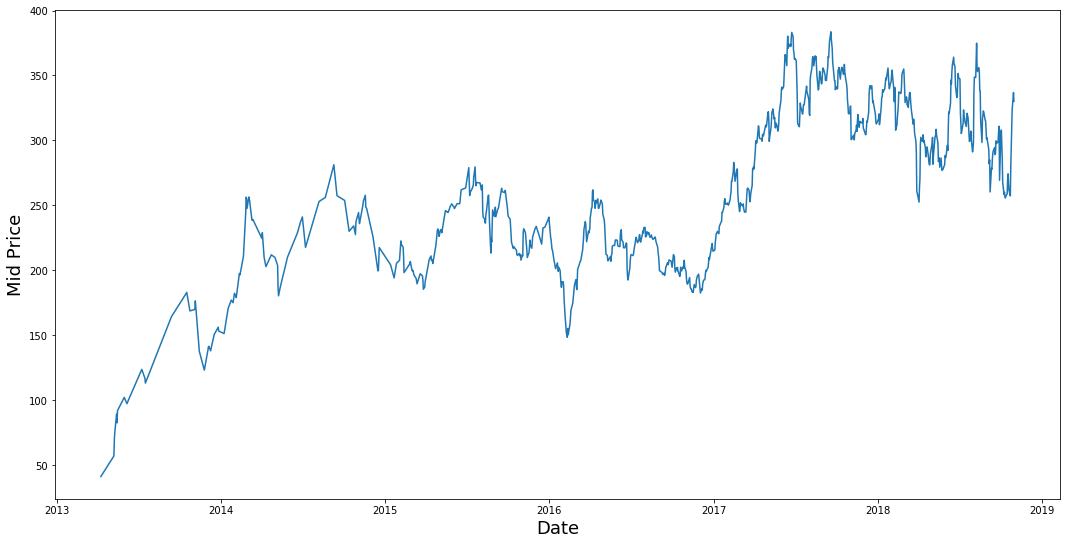

In [10]:
plt.figure(figsize = (18,9))
plt.plot(df["Date"],(df['Low']+df['High'])/2.0)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Machine Learning

### EMA

In order for us begin modelling we need a column to predict on, however there are 6 columns: `Volume`, `Open`, `Close`, `Low`, `High`, `Adj Close`. We decided the best feature to predict is rather none of these and actually an average of the `Low` and `High` for that day of Tesla's stock

In [11]:
# First calculate the mid prices from the highest and lowest
high_prices = np.matrix(df.loc[:,'High'])
low_prices = np.matrix(df.loc[:,'Low'])
mid_prices = (high_prices+low_prices)/2.0

Before we begin fitting our LSTM model we need to a baseline model to compare it to which we chose as Exponential Moving Average.

https://www.investopedia.com/terms/e/ema.asp

In [12]:
train_data = mid_prices[0,:800]
test_data = mid_prices[0,800:]

We now scale the data in order to smooth it nicely for the EMA model.

In [13]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [14]:
# Smooth the data with training data
smoothing_window_size = 10
for di in range(0,100,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [15]:
train_data = train_data.reshape(-1)

test_data = scaler.transform(test_data).reshape(-1)

In [16]:
test_train_data = train_data.copy()
EMA = 0.0
gamma = 0.1
for ti in range(800):
    EMA = gamma*train_data[0,ti] + (1-gamma)*EMA
    test_train_data[0,ti] = EMA

all_mid_data = np.concatenate([test_train_data.T,test_data.reshape(103, 1)],axis=0)

We know predict the next day price using Exponential Moving Average.

In [19]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

mse_test_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[0,pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[0,pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

for pred_idx in range(800,903):

    running_mean = running_mean*decay + (1.0-decay)*run_avg_predictions[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_test_errors.append((run_avg_predictions[-1]-test_data[pred_idx - 800])**2)
    run_avg_x.append(date) 
    

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_test_errors)))

MSE error for EMA averaging: 0.00650
MSE error for EMA averaging: 0.01135


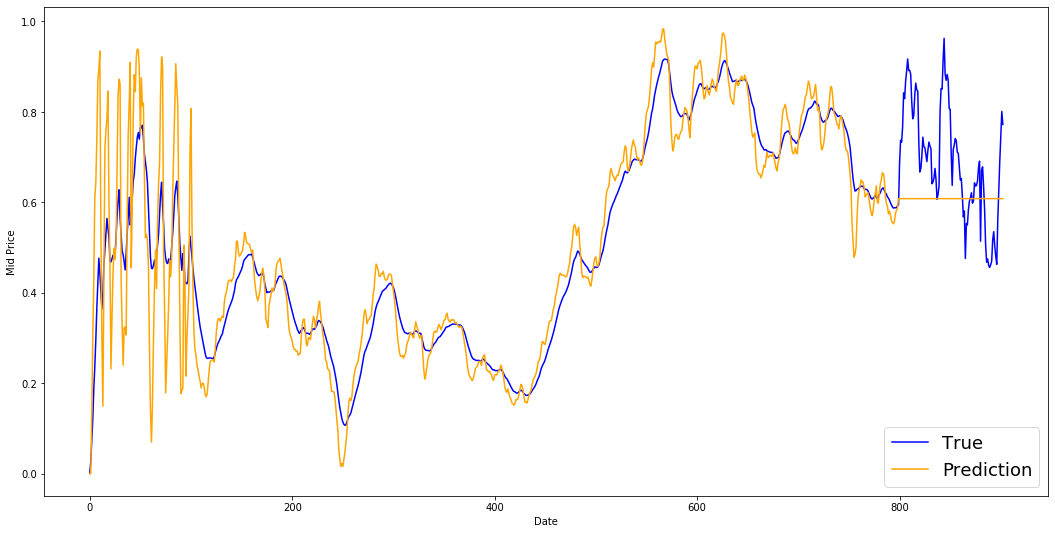

In [20]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,903),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### LSTM

In [22]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

Using TensorFlow backend.


Convert the data into time series data for LSTM

In [23]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [24]:
high_prices = df["High"]
low_prices = df["Low"]
df["mid_prices"] = (high_prices+low_prices)/2.0

Functions I make to make the ML Pipeline more readable

In [25]:
def scale_df(values):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaler,scaled

def reframe_df(df):
    # frame as supervised learning
    reframed = series_to_supervised(df, 1, 1)

    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
    return reframed

def train_test_split(values, limit):
    # split into train and test sets
    train = values[:limit, :]
    test = values[limit:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    return train_X, train_y, test_X, test_y

def reshape_features(train_X, test_X):
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, test_X

def plot_history(history):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

Now we fit the LSTM model ...

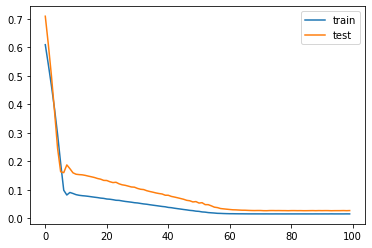

Test Min-Max RMSE: 0.037
Test Inverted Scale RMSE: 12.707


In [42]:
# Get the columns we need
df = df.sort_values('Date')
main_df = df[['sell','buy','calls','puts','score','mid_prices']]
values = main_df.values


values = values.astype('float32')

# normalize features
scaler, scaled = scale_df(values)
#frame as supervised learning
reframed = reframe_df(scaled)

# Train Test Split
train_X, train_y, test_X, test_y = train_test_split(reframed.values, 800)

# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_features(train_X, test_X)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)


# plot history
plot_history(history)
    
# make a prediction
tests = test_y.reshape((len(test_y), 1))
test = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#display(concatenate((test[:, 1:],tests), axis=1))
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, 1:],yhat), axis=1)
inv_yhat_ = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,5]
inv_yhat_ = inv_yhat_[:,5]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, 1:],test_y), axis=1)
inv_y_ = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,5]
inv_y_ = inv_y_[:,5]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
rmse_ = sqrt(mean_squared_error(inv_y_, inv_yhat_))


print('Test Min-Max RMSE: %.3f' % rmse)
print('Test Inverted Scale RMSE: %.3f' % rmse_)

Text(0, 0.5, 'Stock MidPrices')

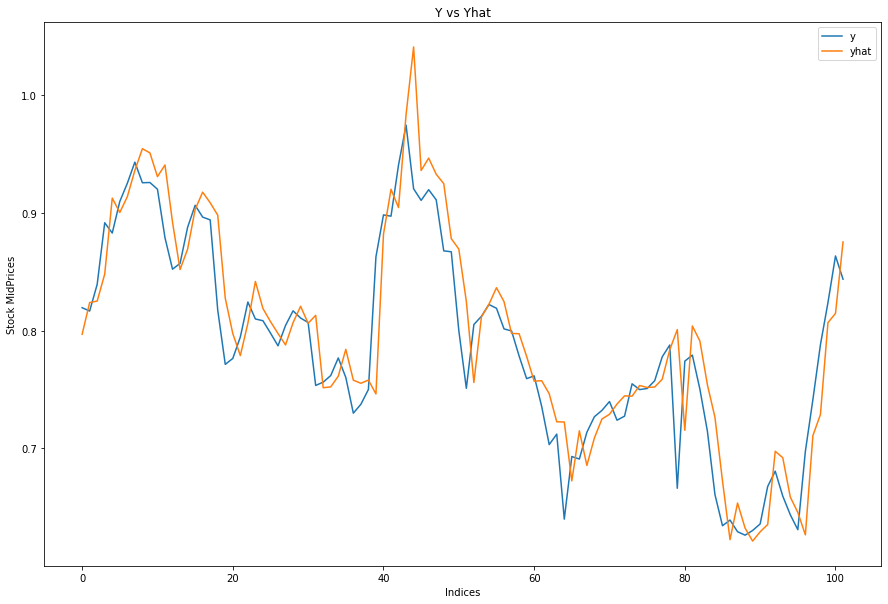

In [43]:
pd.DataFrame(data = {'y':inv_y, 'yhat': inv_yhat}).plot(figsize=(15,10))
plt.title("Y vs Yhat")
plt.xlabel("Indices")
plt.ylabel("Stock MidPrices")

### Multi-Variate LSTM

In [45]:
def reframe_df(df):
    # frame as supervised learning
    reframed = series_to_supervised(df, 1, 1)

    # drop columns we don't want to predict
    #reframed.drop(reframed.columns, axis=1, inplace=True)
    return reframed

def train_test_split(values, limit):
    # split into train and test sets
    train = values[:limit, :]
    test = values[limit:, :]
    # split into input and outputs
    train_X, train_y = train[:, :6], train[:, 6:]
    test_X, test_y = test[:, :6], test[:, 6:]
    return train_X, train_y, test_X, test_y

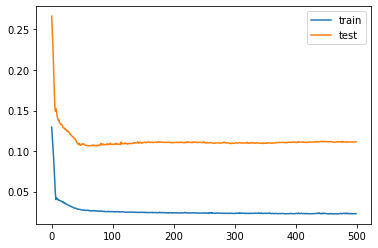

Test Min-Max RMSE: 0.187
Test Inverted Scale RMSE: 267.456


In [47]:
# Get the columns we need
df = df.sort_values('Date')
main_df = df[['sell','buy','calls','puts','score','mid_prices']]
values = main_df.values


# ensure all data is float
values = values.astype('float32')

# normalize features
scaler, scaled = scale_df(values)
#frame as supervised learning
reframed = reframe_df(scaled)


# Train Test Split
train_X, train_y, test_X, test_y = train_test_split(reframed.values, 800)

# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_features(train_X, test_X)

# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1]))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)


# plot history
plot_history(history)
    
# make a prediction
tests = test_y.reshape((len(test_y), train_y.shape[1]))
test = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhat = model.predict(test_X)

inv_yhat_ = scaler.inverse_transform(yhat)
inv_y_ = scaler.inverse_transform(test_y)

rmse = np.sqrt(mean_squared_error(yhat, test_y))
rmse_ = np.sqrt(mean_squared_error(inv_y_, inv_yhat_))

print('Test Min-Max RMSE: %.3f' % rmse)
print('Test Inverted Scale RMSE: %.3f' % rmse_)

We can see that in order to do multi-step prediction our models have to be much worse in order to compensate with doing predictions on multiple columns

### LSTM (Only Stock Data)

Now we make a LSTM model that will only be fit on the stock data. Which can be used for multi step predictions and one day predictions.

In [48]:
def scale_df(values):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaler, scaled

def reframe_df(df):
    # frame as supervised learning
    reframed = series_to_supervised(df, 1, 1)

    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
    return reframed

def train_test_split(values, limit):
    # split into train and test sets
    values = reframed.values
    limit = 800
    train = values[:limit, :]
    test = values[limit:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    return train_X, train_y, test_X, test_y

def reshape_features(train_X, test_X):
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, test_X

def plot_history(history):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

Train on 800 samples, validate on 102 samples
Epoch 1/100
 - 0s - loss: 0.5516 - val_loss: 0.6571
Epoch 2/100
 - 0s - loss: 0.4972 - val_loss: 0.5962
Epoch 3/100
 - 0s - loss: 0.4409 - val_loss: 0.5320
Epoch 4/100
 - 0s - loss: 0.3813 - val_loss: 0.4632
Epoch 5/100
 - 0s - loss: 0.3173 - val_loss: 0.3884
Epoch 6/100
 - 0s - loss: 0.2479 - val_loss: 0.3062
Epoch 7/100
 - 0s - loss: 0.1732 - val_loss: 0.2165
Epoch 8/100
 - 0s - loss: 0.1015 - val_loss: 0.1289
Epoch 9/100
 - 0s - loss: 0.0727 - val_loss: 0.0765
Epoch 10/100
 - 0s - loss: 0.0766 - val_loss: 0.0615
Epoch 11/100
 - 0s - loss: 0.0796 - val_loss: 0.0597
Epoch 12/100
 - 0s - loss: 0.0790 - val_loss: 0.0613
Epoch 13/100
 - 0s - loss: 0.0773 - val_loss: 0.0635
Epoch 14/100
 - 0s - loss: 0.0754 - val_loss: 0.0651
Epoch 15/100
 - 0s - loss: 0.0736 - val_loss: 0.0658
Epoch 16/100
 - 0s - loss: 0.0719 - val_loss: 0.0652
Epoch 17/100
 - 0s - loss: 0.0705 - val_loss: 0.0640
Epoch 18/100
 - 0s - loss: 0.0693 - val_loss: 0.0628
Epoch 19/

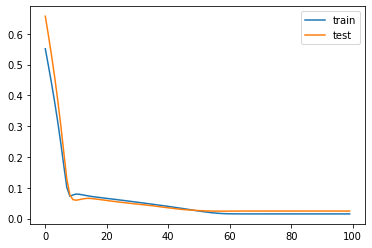

Test Min-Max RMSE: 0.034
Test Inverted Scale RMSE: 11.766


In [54]:
# Get the columns we need
df = df.sort_values('Date')
main_df = df[['mid_prices']]
values = main_df.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler, scaled = scale_df(values)
#frame as supervised learning
#reframed = reframe_df(scaled)
reframed = series_to_supervised(scaled, 1, 1)


# Train Test Split
train_X, train_y, test_X, test_y = train_test_split(values, 800)

# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_features(train_X, test_X)
 
# design network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


# plot history
plot_history(history)
    
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, 1:],yhat), axis=1)
inv_yhat_ = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat_ = inv_yhat_[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, 1:],test_y), axis=1)
inv_y_ = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y_ = inv_y_[:,0]
rmse = sqrt(mean_squared_error(inv_y,inv_yhat))
rmse_ = sqrt(mean_squared_error(inv_y_, inv_yhat_))

print('Test Min-Max RMSE: %.3f' % rmse)
print('Test Inverted Scale RMSE: %.3f' % rmse_)


We can see that the LSTM model with just the stock data performs the best